In [36]:
import xarray as xr
import xeofs as xe
import matplotlib.pyplot as plt

In [44]:
sst = xr.open_dataset('sst.mnmean.nc')

In [41]:
def linear_pca(data, n_pcs = 8):
    pca = xe.single.EOF(n_modes = n_pcs)
    pcs = pca.fit_transform(data, dim = 'time')
    return pca, pcs

def plot_pc_info(pca, pcs, mode = 1):
    fig, ax = plt.subplots(2)
    fig.tight_layout()
    fig.suptitle(f"PC{mode} of SST data and components")
    pcs.sel(mode = mode).plot(ax = ax[0])
    pca.components().sel(mode = mode).plot(ax = ax[1])

In [24]:
pca, sst_pcs = linear_pca(sst.sst)

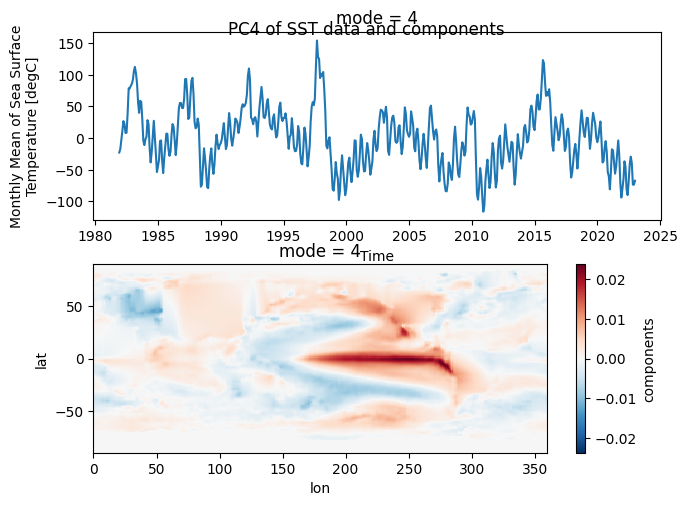

In [43]:
plot_pc_info(pca, sst_pcs, mode = 4)